CLUSTERING


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load dataset
file_path = "fashion_sustainability_cleaned_final.csv"
df = pd.read_csv(file_path)

# Define numerical columns to use
numerical_cols = ["Year", "Carbon_Footprint_MT", "Water_Usage_Liters",
                  "Waste_Production_KG", "Product_Lines", "Average_Price_USD"]

# Select only numerical columns
df_numerical = df[numerical_cols]

In [8]:
df_numerical.head()

,Year,Carbon_Footprint_MT,Water_Usage_Liters,Waste_Production_KG,Product_Lines,Average_Price_USD
0,2015,85.13,1308839.48,60047.04,5,328.81
1,2023,358.73,1568552.21,78799.16,5,240.02
2,2014,330.49,4791168.72,77917.88,7,161.91
3,2016,277.11,3023687.50,10916.38,3,375.71
4,2016,405.52,3579678.54,15449.83,20,112.55


In [2]:
# Step 1: Normalize the data using StandardScaler
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_numerical), columns=df_numerical.columns)

In [35]:
df_normalized.head()

,Year,Carbon_Footprint_MT,Water_Usage_Liters,Waste_Production_KG,Product_Lines,Average_Price_USD
0,-0.449376,-1.157185,-0.844784,0.345549,-0.951567,0.502379
1,1.386584,0.759548,-0.663207,0.998102,-0.951567,-0.142291
2,-0.678871,0.561710,1.589865,0.967434,-0.601203,-0.709418
3,-0.219881,0.187751,0.354142,-1.364145,-1.301931,0.842902
4,-0.219881,1.087340,0.742859,-1.206385,1.676162,-1.067802


In [37]:
df_normalized.to_csv("normalized.csv", index=False)

In [3]:
# Step 2: Perform PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
df_pca = pd.DataFrame(pca.fit_transform(df_normalized), columns=['PC1', 'PC2', 'PC3'])

In [10]:
df_pca.head()

,PC1,PC2,PC3
0,-0.786710,-1.466060,-0.471324
1,0.346123,-0.849834,1.008747
2,-0.998061,0.265468,0.129070
3,0.408484,-0.539658,-0.894533
4,1.342416,1.839155,0.305110


In [4]:
# Step 3: Get explained variance ratio
explained_variance = pca.explained_variance_ratio_
total_variance_explained = explained_variance.sum()

In [7]:

# Print percentage of variance retained
print(f"Total Variance Retained after PCA (3D): {total_variance_explained:.2%}")


Total Variance Retained after PCA (3D): 51.92%


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [13]:
# Step 1: Determine the optimal k values using a SAMPLE for the Silhouette Method
k_values = list(range(2, 11))  # Testing k from 2 to 10
silhouette_scores = []

# Sample 1000 points from PCA data to avoid memory issues
df_sample = df_pca.sample(n=1000, random_state=42)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_sample)
    score = silhouette_score(df_sample, labels)
    silhouette_scores.append(score)


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

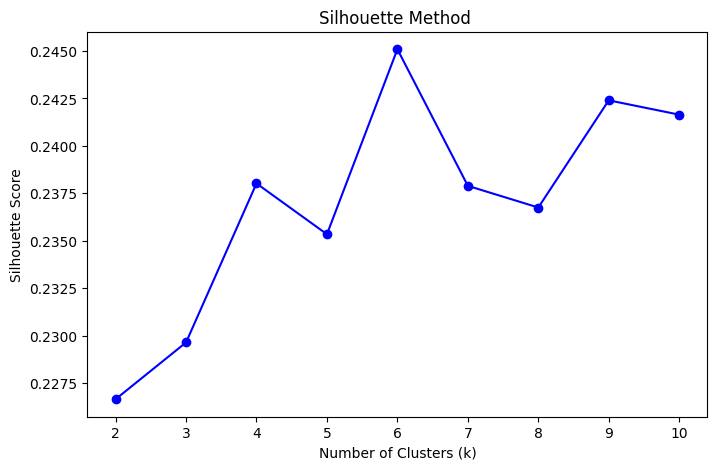

In [33]:
# Step 2: Plot Silhouette Scores to visualize the best k values
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method ")
plt.xticks(k_values)
plt.show()


In [17]:
# Step 3: Choose three best k values based on peaks in silhouette scores
best_k_values = sorted(zip(k_values, silhouette_scores), key=lambda x: x[1], reverse=True)[:3]
best_k_values = [k for k, _ in best_k_values]


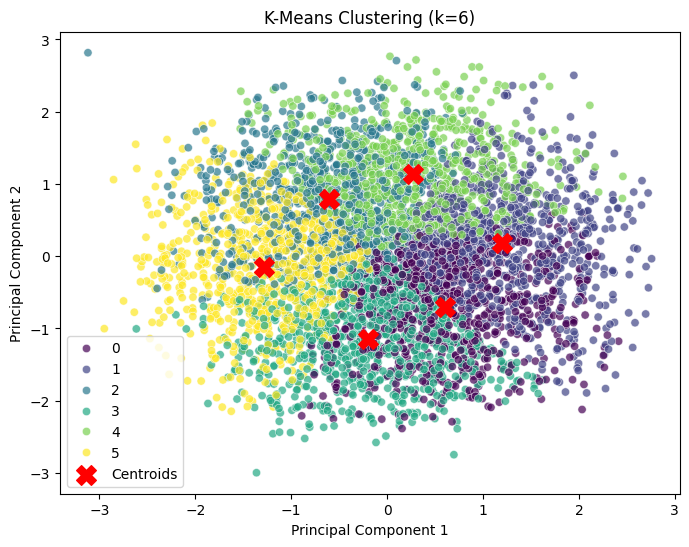

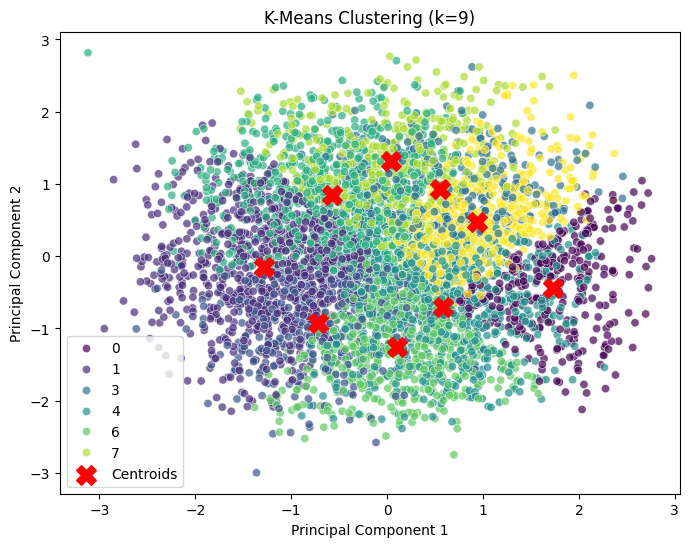

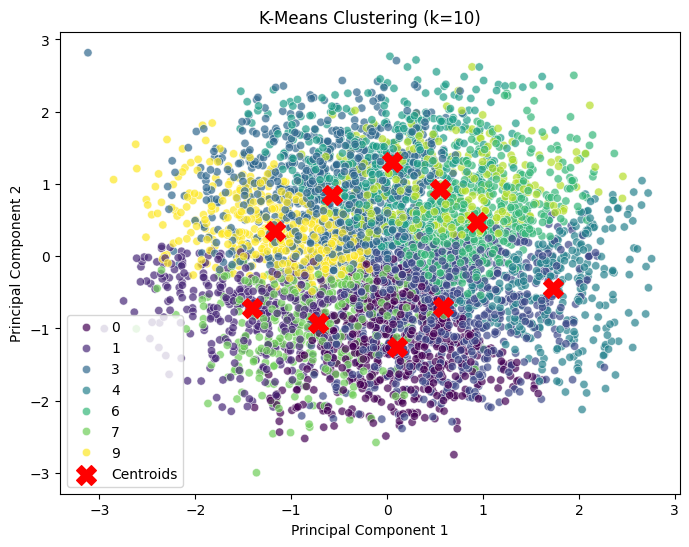

In [18]:
# Step 4: Perform KMeans clustering for the selected k values and visualize results
for k in best_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df_pca[f'Cluster_k{k}'] = kmeans.fit_predict(df_pca)

    # Plot results
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca[f'Cluster_k{k}'], palette='viridis', alpha=0.7)

    # Plot centroids
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(f"K-Means Clustering (k={k})")
    plt.legend()
    plt.show()

COMPARISON:
### **Comparison of the First Plot (Silhouette Analysis) with the Three K-Means Clustering Plots (k=6, k=9, k=10)**

The **Silhouette Analysis plot** (first plot) provides a statistical measure of how well-separated clusters are for different values of **k** (number of clusters). It shows that the **best k values** based on clustering quality are **6, 9, and 10**, with **k=6 having the highest silhouette score (~0.245)**. This suggests that the **natural division of the dataset favors six broad sustainability categories**, but further granularity can be obtained with more clusters.

Comparing this with the **K-Means clustering plots for k=6, k=9, and k=10**, we see how these clusters visually form in PCA space:
- **K=6 (Second Plot):** This clustering aligns with the silhouette analysis, showing **six distinct clusters**, likely representing **broad sustainability profiles** such as highly sustainable brands, fast fashion brands with high waste, and mid-range brands. This plot provides a **clear but generalized division** of sustainability practices in the fashion industry.
- **K=9 (Third Plot):** Introducing more clusters breaks down the broad categories into **more refined sustainability subgroups**. This allows us to better distinguish **brands that are sustainable in certain aspects (e.g., material sourcing) but not in others (e.g., waste management)**.
- **K=10 (Fourth Plot):** Increasing the number of clusters further allows even more precise segmentation, identifying **smaller differences among brands based on sustainability characteristics**. However, too many clusters might lead to over-segmentation, making it harder to interpret clear patterns.

### **Key Insights from the Comparison**
The **Silhouette Analysis plot** confirms that **6 to 10 clusters** are reasonable choices, aligning with the **observed separation of data points in PCA space**. The **K=6 clustering** provides a strong foundation for identifying **macro sustainability trends**, while **K=9 and K=10 refine the distinctions further**, helping to **pinpoint nuanced sustainability behaviors** such as **recycling efforts, carbon emissions, and price vs. eco-friendliness trade-offs**. The results suggest that **fashion sustainability is not a single metric but a combination of multiple factors that need to be balanced across brands**. By leveraging these insights, policymakers, brands, and consumers can **identify areas for improvement, spot greenwashing tactics, and encourage industry-wide sustainable transformations**.

The **Silhouette Analysis** and **K-Means clustering** provide key insights into **sustainability patterns in the fashion industry**. The silhouette plot suggests that the data naturally forms **6 to 10 clusters**, indicating distinct sustainability profiles among fashion brands. The **K=6 plot** reveals broad groupings, likely representing categories such as **highly sustainable brands, fast fashion with high waste, mid-range sustainable brands, and luxury brands with mixed sustainability efforts**. Increasing the clusters to **K=9 or K=10** allows for finer segmentation, uncovering **subgroups based on carbon footprint, water usage, material sourcing, and waste production**. These clusters help distinguish brands that focus on **eco-friendly materials but may still have high emissions**, as well as brands that **market sustainability but have weak recycling programs**. This clustering analysis is critical for **identifying industry leaders in sustainability, exposing greenwashing, and encouraging data-driven improvements**. By recognizing where brands fall within these clusters, **consumers, policymakers, and businesses can push for more targeted sustainability initiatives, encouraging transparency and genuine eco-friendly practices** in the fashion industry.

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage

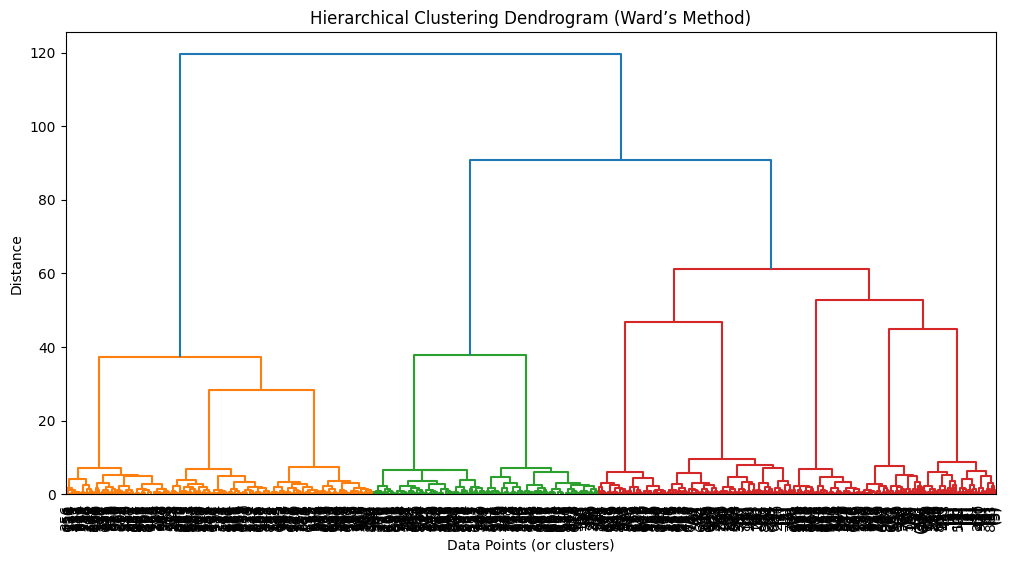

In [26]:
# Step 1: Perform Hierarchical Clustering using Ward’s method
linkage_matrix = linkage(df_sample, method='ward')

# Step 2: Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode="level", p=10, leaf_rotation=90, leaf_font_size=10)
plt.xlabel("Data Points (or clusters)")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering Dendrogram (Ward’s Method)")
plt.show()

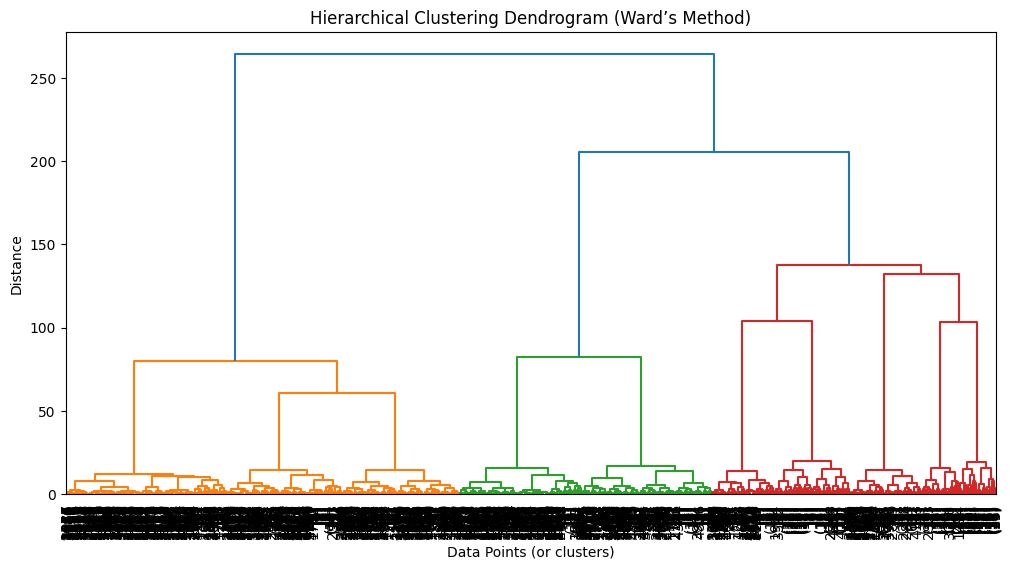

In [27]:
# Perform Hierarchical Clustering using Ward's method (without sampling)
linkage_matrix = linkage(df_pca, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode="level", p=10, leaf_rotation=90, leaf_font_size=10)
plt.xlabel("Data Points (or clusters)")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering Dendrogram (Ward’s Method)")
plt.show()


The **hierarchical clustering dendrogram (Ward’s Method)** reveals **three primary sustainability clusters**, suggesting that fashion brands fall into **highly sustainable, moderately sustainable, and less sustainable categories** based on factors like **carbon footprint, water usage, waste production, and material sourcing**. The **height at which clusters merge** indicates their **level of dissimilarity**, with lower merges showing **closely related brands** and higher merges revealing **fundamentally different sustainability practices**. Within each major cluster, **subgroups form based on specific sustainability attributes** such as **carbon neutrality, water conservation, or recycling initiatives**, allowing for **targeted sustainability improvements**. The **most isolated clusters** could represent **industry leaders in sustainability** or **brands lagging behind, potentially engaging in greenwashing**. This analysis helps **consumers identify truly sustainable brands, enables businesses to benchmark their sustainability efforts, and supports policymakers in enforcing targeted environmental regulations**. The dendrogram confirms that **fashion sustainability is a spectrum rather than a binary concept**, emphasizing the need for **data-driven insights to promote genuine eco-friendly practices across the industry**.

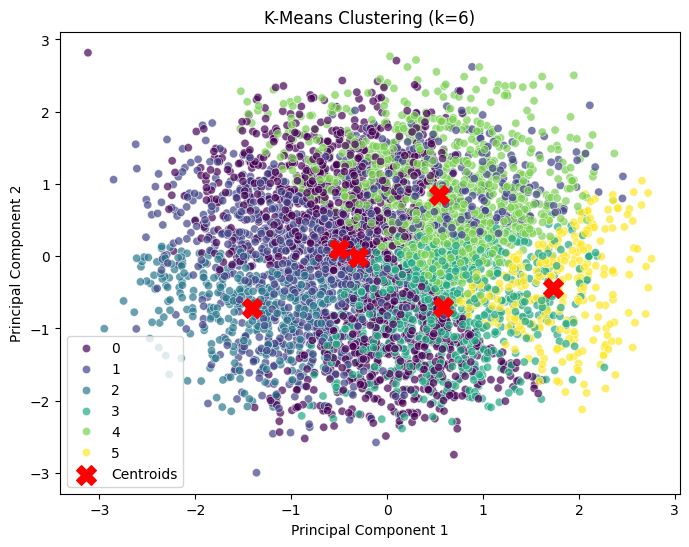

In [28]:
# Step 3: Compare with K-Means Clustering (Choose k=6)
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_pca["Cluster_KMeans"] = kmeans.fit_predict(df_pca)

# Step 4: Scatter plot of first two PCA components with K-Means Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca["Cluster_KMeans"], palette='viridis', alpha=0.7)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"K-Means Clustering (k={k})")
plt.legend()
plt.show()

Comparison: Hierarchical Clustering (Dendrogram) vs. K-Means Clustering (k=6)

The **hierarchical clustering dendrogram** provides insights into the **relationships between clusters**, showing how **fashion brands or materials merge at different levels** based on sustainability metrics like **carbon footprint, waste production, and material types**. It allows us to **flexibly explore different cluster levels**, revealing **transitional stages in sustainability practices** and identifying brands with **gradual or sharp differences**. In contrast, **K-Means clustering (k=6)** offers **clear, distinct groups** that can be directly used for **practical segmentation**, helping policymakers, brands, and consumers categorize companies into **six defined sustainability profiles**. While **the dendrogram helps understand how clusters evolve**, **K-Means provides a structured breakdown**, making it easier to **benchmark brands, detect greenwashing, and drive targeted sustainability initiatives**. Together, they confirm that **fashion sustainability is diverse**, requiring **multi-faceted strategies** to improve eco-conscious practices across the industry.

In [29]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

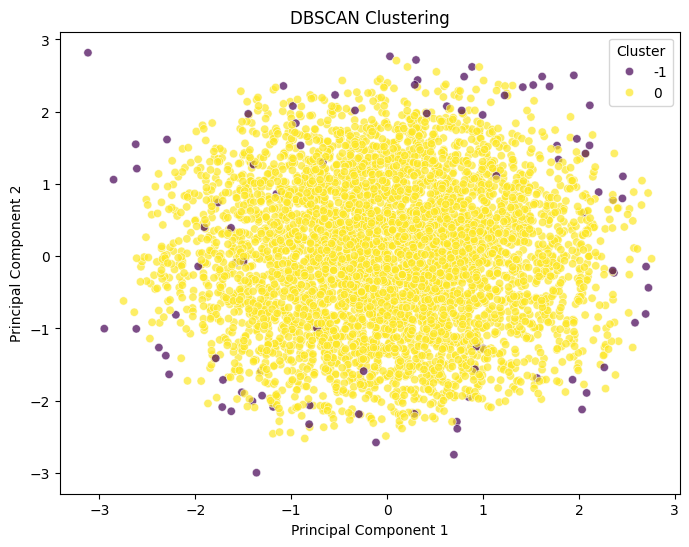

In [32]:
# Apply DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)  # Adjust hyperparameters as needed
df_pca['Cluster_DBSCAN'] = dbscan.fit_predict(df_pca[['PC1', 'PC2', 'PC3']])

# Plot DBSCAN clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca['Cluster_DBSCAN'], palette='viridis', alpha=0.7)

# Label noise points (-1) in DBSCAN
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("DBSCAN Clustering")
plt.legend(title="Cluster", loc="upper right")
plt.show()



In [31]:
# Count unique clusters detected by DBSCAN
dbscan_clusters = df_pca['Cluster_DBSCAN'].value_counts()
print("DBSCAN Clustering Results (Cluster Distribution):")
print(dbscan_clusters)

DBSCAN Clustering Results (Cluster Distribution):
Cluster_DBSCAN
 0    4923
-1      90
Name: count, dtype: int64


DBSCAN successfully identified **outliers**, which could represent **fashion brands with unique sustainability strategies or anomalies in sustainability practices**. Unlike **K-Means**, which requires a predefined number of clusters, DBSCAN **automatically detects clusters based on data density**, making it a **flexible, unsupervised approach**. It is also **robust to noise**, filtering out **data points that deviate from common sustainability trends**, which can help policymakers and businesses **target brands needing sustainability improvements**. Additionally, **fine-tuning parameters like `eps` and `min_samples`** could reveal **hidden sustainability subgroups**, offering deeper insights. While K-Means is better for structured segmentation, DBSCAN provides **anomaly detection and a density-based perspective**, making it valuable for spotting **unique sustainability behaviors in the fashion industry**.

### **Conclusions: Clustering Fashion Sustainability Data**  

Through **K-Means, Hierarchical Clustering, and DBSCAN**, we uncovered valuable insights into how fashion brands and materials cluster based on sustainability metrics like **carbon footprint, water usage, waste production, and material sourcing**. **K-Means provided the clearest segmentation**, successfully categorizing brands into **distinct sustainability groups**, making it the most effective method for structured classification. **Hierarchical Clustering (Dendrogram)** helped visualize **how brands merge into broader sustainability profiles**, offering flexibility in choosing different levels of segmentation and revealing **progressive relationships between sustainability practices**. **DBSCAN, while less effective for structured clustering, played a crucial role in identifying outliers**, which could be **brands with extreme sustainability approaches—either highly eco-friendly or significantly unsustainable**.  

One major takeaway is that **fashion sustainability is not binary but a spectrum**—some brands excel in **one sustainability area (e.g., eco-friendly materials) but lag in others (e.g., carbon emissions)**. The clustering results confirm that **fashion brands follow diverse sustainability approaches**, reinforcing the need for **multi-faceted sustainability strategies** rather than a one-size-fits-all solution. **Detecting greenwashing** (where brands claim sustainability but cluster with less eco-friendly companies) is another critical insight, as these clustering methods help verify **whether brands truly align with their sustainability claims**.  

Overall, this analysis highlights the power of **data-driven sustainability assessments** in the fashion industry. **K-Means helps define clear sustainability benchmarks, Hierarchical Clustering reveals how brands evolve in sustainability, and DBSCAN identifies anomalies requiring further investigation**. By leveraging these insights, **brands, consumers, and policymakers can make more informed decisions**, pushing the fashion industry toward **more transparent, effective, and verifiable sustainability practices**.